In [1]:
import os
import csv 
import sys 
import numpy as np
from scipy import sparse
from collections import Counter
import xgboost as xgb

try:
    import xml.etree.cElementTree as ET
except ImportError:
    import xml.etree.ElementTree as ET


from sklearn.cross_validation import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer

import util

/Users/fanxu/anaconda2/envs/my-rdkit-env/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
import csv 
import sys 

def reorder_submission(file_to_reorder, newfile_name = "experiment_results.csv"):
    # READ IN KEYS IN CORRECT ORDER AS LIST
    with open('keys.csv','r') as f:
        keyreader = csv.reader(f)
        keys = [key[0] for key in keyreader]

    # READ IN ALL PREDICTIONS, REGARDLESS OF ORDER
    with open(file_to_reorder) as f:
        oldfile_reader = csv.reader(f)
        D = {}
        for i,row in enumerate(oldfile_reader):
            if i == 0:
                continue
            _id, pred = row 
            D[_id] = pred

    # WRITE PREDICTIONS IN NEW ORDER
    with open(newfile_name,'wb') as f:
        writer = csv.writer(f)
        writer.writerow(('Id','Prediction'))
        for key in keys:
            writer.writerow((key,D[key]))

    print("".join(["Reordered ", file_to_reorder," and wrote to ", newfile_name]))

In [3]:
X_train = sparse.load_npz("X_train.npz")
t_train = np.load("t_train.npy")
train_ids = np.load("train_ids.npy")

In [4]:
print X_train.shape
print train_ids.shape

(3086, 29813)
(3086,)


In [60]:
X_test = sparse.load_npz("X_test.npz")
test_ids = np.load("test_ids.npy")

In [6]:
print X_test.shape
print test_ids.shape

(3724, 29813)
(3724,)


In [7]:
y_train = np.zeros((len(t_train),len(util.malware_classes)))
y_train[np.arange(len(t_train)), t_train] = 1
y_train.shape

(3086, 15)

In [8]:
# X_train_bkup = X_train

In [9]:
# X_test_bkup = X_test

In [10]:
X_train = X_train_bkup
X_test = X_test_bkup

In [15]:
print t_train

[ 8 12 10 ..., 13 10 10]


In [33]:
param = {'max_depth':2, 'eta':1, 'silent':1, 'objective':'multi:softprob', 'num_class':15 }
dtrain = xgb.DMatrix(X_train, label = t_train)
dtest = xgb.DMatrix(X_test)
num_round = 2
bst = xgb.train(param, dtrain, num_round)
cv = xgb.cv(param, dtrain, 999, nfold=5, early_stopping_rounds=10, verbose_eval=1)
# make prediction
# preds = bst.predict(dtest)
# print preds

[0]	train-merror:0.116657+0.00914223	test-merror:0.129954+0.0238309
[1]	train-merror:0.125811+0.0201362	test-merror:0.15101+0.0241221
[2]	train-merror:0.0827126+0.0035979	test-merror:0.118284+0.0194618
[3]	train-merror:0.0753406+0.00615803	test-merror:0.113747+0.0157347
[4]	train-merror:0.067483+0.00854467	test-merror:0.112774+0.0149518
[5]	train-merror:0.0603542+0.00828676	test-merror:0.111155+0.0151997
[6]	train-merror:0.0531434+0.00680629	test-merror:0.108885+0.0160606
[7]	train-merror:0.0468246+0.00629489	test-merror:0.108562+0.0149649
[8]	train-merror:0.0435032+0.00553464	test-merror:0.105645+0.0126147
[9]	train-merror:0.0391282+0.0052149	test-merror:0.10856+0.0112754
[10]	train-merror:0.036941+0.00490272	test-merror:0.107264+0.010216
[11]	train-merror:0.0353208+0.00490988	test-merror:0.104023+0.0111452
[12]	train-merror:0.0326476+0.00392488	test-merror:0.105968+0.0113001
[13]	train-merror:0.0307844+0.00328253	test-merror:0.106615+0.0113321
[14]	train-merror:0.028597+0.00272009	te

In [19]:
print "making predictions..."
results = np.argmax(preds, axis=1)

making predictions...


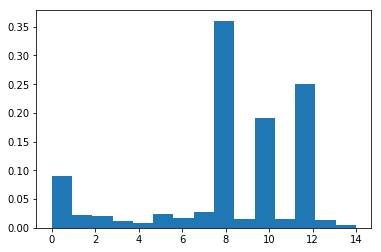

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(results, bins=15, normed = True)
plt.show()

In [37]:
mean = 1
min_mean = 1

for num_round in [2,6,10]:
    for max_depth in [2, 4, 6]:
        for eta in np.arange(0.05, 0.25, 0.05):
            for min_child_weight in [1, 2]:
                for col_sample in [0.5, 1]:
                    print("Test params: {}, {}, {}, {}, {}".format(num_round, max_depth, eta, min_child_weight, col_sample))
                    param = {'max_depth':max_depth, 'eta':eta, 'min_child_weight':min_child_weight, 'colsample_bytree':col_sample, 'objective':'multi:softprob', 'num_class':15 }
                    dtrain = xgb.DMatrix(X_train, label = t_train)
                    dtest = xgb.DMatrix(X_test)
                    # num_round = 2
                    bst = xgb.train(param, dtrain, num_round)
                    
                    cv = xgb.cv(param, dtrain, 999, nfold=5, early_stopping_rounds=10)
                    mean = cv['test-merror-mean'].min()
                    boost_rounds = cv['test-merror-mean'].argmin()
                    print("\ttest-merror {} for {} rounds".format(mean, boost_rounds))
    
                    if mean < min_mean:
                        min_mean = mean
                        best_params = (num_round,max_depth,eta,min_child_weight,col_sample)

Test params: 2, 2, 0.05, 1, 0.5


/Users/fanxu/anaconda2/envs/my-rdkit-env/lib/python2.7/site-packages/ipykernel_launcher.py:18: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.


	test-merror 0.116666 for 29 rounds
Test params: 2, 2, 0.05, 1, 1
	test-merror 0.1085652 for 116 rounds
Test params: 2, 2, 0.05, 2, 0.5
	test-merror 0.1046756 for 132 rounds
Test params: 2, 2, 0.05, 2, 1
	test-merror 0.1182866 for 17 rounds
Test params: 2, 2, 0.1, 1, 0.5
	test-merror 0.1004634 for 87 rounds
Test params: 2, 2, 0.1, 1, 1
	test-merror 0.1030542 for 95 rounds
Test params: 2, 2, 0.1, 2, 0.5
	test-merror 0.1017588 for 100 rounds
Test params: 2, 2, 0.1, 2, 1
	test-merror 0.1150464 for 27 rounds
Test params: 2, 2, 0.15, 1, 0.5
	test-merror 0.1007872 for 66 rounds
Test params: 2, 2, 0.15, 1, 1
	test-merror 0.1011102 for 85 rounds
Test params: 2, 2, 0.15, 2, 0.5
	test-merror 0.1166668 for 11 rounds
Test params: 2, 2, 0.15, 2, 1
	test-merror 0.0998146 for 93 rounds
Test params: 2, 2, 0.2, 1, 0.5
	test-merror 0.1017596 for 38 rounds
Test params: 2, 2, 0.2, 1, 1
	test-merror 0.1001388 for 75 rounds
Test params: 2, 2, 0.2, 2, 0.5
	test-merror 0.0962486 for 74 rounds
Test params: 2, 

KeyboardInterrupt: 

In [ ]:
print("Best params: {}, {}, {}, {}, {}, min_mean: {}".format(best_params[0], best_params[1], best_params[2], best_params[3], best_params[4], min_mean))

In [ ]:
Test params: 2, 6, 0.2, 1, 1
	test-merror 0.093334 for 25 rounds    >>>>> 0.811xx
Test params: 2, 4, 0.15, 1, 0.5
	test-merror 0.0933316 for 49 rounds   >>>>> 0.82158
Test params: 2, 4, 0.1, 1, 0.5
	test-merror 0.093983 for 68 rounds    >>>> 0.825xx

In [48]:
param = {'max_depth':4, 'eta':0.1, 'min_child_weight':1, 'col_sample':0.5, 'objective':'multi:softprob', 'num_class':15 }
dtrain = xgb.DMatrix(X_train, label = t_train)
dtest = xgb.DMatrix(X_test)
num_round = 200
bst = xgb.train(param, dtrain, num_round)
# cv = xgb.cv(param, dtrain, 999, nfold=5, early_stopping_rounds=10, verbose_eval=1)
# make prediction
preds = bst.predict(dtest)
# print preds

In [49]:
print "making predictions..."
results = np.argmax(preds, axis=1)

making predictions...


In [52]:
print t_train

[ 8 12 10 ..., 13 10 10]


In [50]:
util.write_predictions(results, test_ids, "boost.csv")
reorder_submission("boost.csv", "boost_200_4_01_1_05.csv")

Reordered boost.csv and wrote to boost_200_4_01_1_05.csv


In [145]:
X_train1 = sparse.load_npz("X_train.npz")
t_train = np.load("t_train.npy")
train_ids = np.load("train_ids.npy")

In [146]:
X_test = sparse.load_npz("X_test.npz")
test_ids = np.load("test_ids.npy")
print X_test.shape

(3724, 29813)


In [147]:
dtrain = xgb.DMatrix(X_train1, label = t_train)
dtest = xgb.DMatrix(X_test)
print X_test.shape

(3724, 29813)


In [138]:
#X_train = X_train.todense()
#X_test = X_test.todense()

In [148]:
from sklearn.cross_validation import StratifiedKFold as KFold
import pandas as pd
params = [{'max_depth':4, 'eta': 0.15, 'min_child_weight':1, 'colsample_bytree':0.5, 'objective':'multi:softprob', 'num_class':15 }]

for param in params:
    print param
    labels = t_train
    bst = xgb.train(param, dtrain, 70)
    preds = bst.predict(dtest)
    labels_test = np.argmax(preds, axis=1)
    
    
    kf = KFold(t_train, n_folds=4)
    
    X = X_train1
    stack_train = np.zeros((test_ids.shape[0],15)) # 15 classes.
    for i, (train_fold, validate) in enumerate(kf):
        print i
        print X_test.shape
        X_train_ = X_test[train_fold,:]   
        X_validate_ = X_test[validate,:]
        labels_train_ = labels_test[train_fold]
        labels_validate_ = labels_test[validate]
        
        print X_train_.shape
        print X_validate_.shape
        X_train_ = sparse.vstack((X, X_train_))
        print labels.shape
        print labels_train_.shape
        labels_train_ = np.concatenate((labels, labels_train_))
        # clf.fit(X_train,labels_train)
        
        dtrain_ = xgb.DMatrix(X_train_, label = labels_train_)
        bst = xgb.train(param, dtrain_, 70)
        dtest_ = xgb.DMatrix(X_validate_)
        stack_train[validate] = bst.predict(dtest_)

    results = np.argmax(stack_train, axis=1)
    print results
    util.write_predictions(results, test_ids, "boost.csv")
    reorder_submission("boost.csv", "semi_boost_70_4_015_1_05.csv")

{'num_class': 15, 'min_child_weight': 1, 'eta': 0.15, 'objective': 'multi:softprob', 'colsample_bytree': 0.5, 'max_depth': 4}
0
(3724, 29813)
(2308, 29813)
(778, 29813)
(3086,)
(2308,)
1
(3724, 29813)
(2314, 29813)
(772, 29813)
(3086,)
(2314,)
2
(3724, 29813)
(2317, 29813)
(769, 29813)
(3086,)
(2317,)
3
(3724, 29813)
(2319, 29813)
(767, 29813)
(3086,)
(2319,)
[10  8  8 ...,  0  0  0]
Reordered boost.csv and wrote to semi_boost_70_4_015_1_05.csv


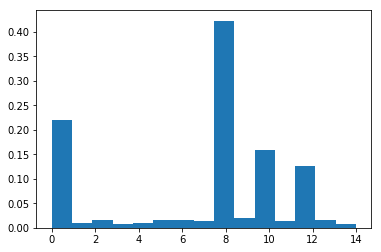

In [149]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(results,bins=15, normed = True)
plt.show()

In [92]:
from sklearn.cross_validation import StratifiedKFold as KFold
import pandas as pd
params = [{'max_depth':4, 'eta': 0.15, 'min_child_weight':1, 'colsample_bytree':0.5, 'objective':'multi:softprob', 'num_class':15 }]

for param in params:
    X = pd.DataFrame(X_train)
    X['label'] = t_train.tolist()
    # X = pd.merge(X, pd.t_train)
    X_test = pd.DataFrame(X_test)

    labels = t_train
    bst = xgb.train(param, dtrain, 70)
    preds = bst.predict(dtest)
    labels_test = np.argmax(preds, axis=1)
    
    X_test['label'] = labels_test.tolist()
    # X_test = pd.merge(X_test, labels_test)
    
    kf = KFold(t_train, n_folds=10)
    X = X.as_matrix()
    X_test = X_test.as_matrix()
    
    stack_train = np.zeros((test_ids.shape[0],15)) # 15 classes.
    for i, (train_fold, validate) in enumerate(kf):
        print i
        X_train_ = X_test[train_fold,:]   
        X_validate_ = X_test[validate,:]
        labels_train_ = labels_test[train_fold]
        labels_validate_ = labels_test[validate]
        
        X_train = np.concatenate((X, X_train))
        labels_train = np.concatenate((labels, labels_train))
        clf.fit(X_train,labels_train)
        stack_train[validate] = clf.predict_proba(X_validate)

    results = np.argmax(stack_train, axis=1)
    print results
    util.write_predictions(results, test_ids, "boost.csv")
    reorder_submission("boost.csv", "semi_boost_70_4_015_1_05.csv")

0


Exception AttributeError: "'Booster' object has no attribute 'handle'" in <bound method Booster.__del__ of <xgboost.core.Booster object at 0x1a257a9410>> ignored


ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [21]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(n_estimators = 1000, n_jobs = -1, class_weight = "balanced")
RF.fit(X_train, y_train)
scores = cross_val_score(RF, X_train, y_train, cv=5)
print "Features: " + str(RF.n_features_) + ("\tAccuracy: %0.5f (+/- %0.5f)" % (scores.mean(), scores.std() * 2))
RF_best = RF
score_best = scores.mean()
X_train_best = X_train
X_test_best = X_test

Features: 29813	Accuracy: 0.85839 (+/- 0.02575)


In [22]:
from sklearn.feature_selection import SelectFromModel
while X_train.shape[1] > 1000:
    model = SelectFromModel(RF, prefit=True, threshold = "0.5*mean")
    X_train = model.transform(X_train)
    ## trick: break if we didn't remove any feature
    if X_train.shape[1] == X_test.shape[1]:
        break
    X_test = model.transform(X_test)
    
    RF = RandomForestClassifier(n_estimators = 1000, n_jobs = -1, class_weight = "balanced")
    RF.fit(X_train, y_train)
    scores = cross_val_score(RF, X_train, y_train, cv=5)
    mean_score = scores.mean()
    print "Features: " + str(RF.n_features_) + ("\tAccuracy: %0.5f (+/- %0.5f)" % (mean_score, scores.std() * 2))
    
    if score_best <= mean_score:
        del X_train_best
        del X_test_best
        RF_best = RF
        score_best = mean_score
        X_train_best = X_train
        X_test_best = X_test

Features: 5222	Accuracy: 0.86260 (+/- 0.02325)
Features: 1779	Accuracy: 0.86131 (+/- 0.02374)
Features: 951	Accuracy: 0.86163 (+/- 0.02617)


In [ ]:
for n in [200, 600, 1000, 1400]:
    for f in ['sqrt', 'log2', None]:
        for c in [None, "balanced"]:
            RF = RandomForestClassifier(n_estimators = n, n_jobs = -1, max_features = f, class_weight = c)
            RF.fit(X_train_best, y_train)
            scores = cross_val_score(RF, X_train_best, y_train, cv=5)
            mean_score = scores.mean()
            print str(n)
            print f
            print c
            print ("\tAccuracy: %0.5f (+/- %0.5f)" % (mean_score, scores.std() * 2))

200
sqrt
None
	Accuracy: 0.87719 (+/- 0.02433)
200
sqrt
balanced
	Accuracy: 0.86423 (+/- 0.02333)
200
log2
None
	Accuracy: 0.87330 (+/- 0.02515)
200
log2
balanced
	Accuracy: 0.86293 (+/- 0.02551)
200
None
None
	Accuracy: 0.88172 (+/- 0.01893)
200
None
balanced
	Accuracy: 0.86131 (+/- 0.03184)
600
sqrt
None
	Accuracy: 0.87686 (+/- 0.02268)
600
sqrt
balanced
	Accuracy: 0.86196 (+/- 0.02475)
600
log2
None
	Accuracy: 0.87394 (+/- 0.02433)
600
log2
balanced
	Accuracy: 0.86066 (+/- 0.02461)
600
None
None
	Accuracy: 0.88172 (+/- 0.01752)
600
None
balanced
	Accuracy: 0.86163 (+/- 0.03144)
1000
sqrt
None
	Accuracy: 0.87654 (+/- 0.02416)
1000
sqrt
balanced
	Accuracy: 0.86293 (+/- 0.02449)


In [24]:
preds = RF.predict(X_test)

In [25]:
# TODO make predictions on text data and write them out
print "making predictions..."
results = np.argmax(preds, axis=1)

print "writing predictions..."
util.write_predictions(results, test_ids, "test.csv")

reorder_submission("test.csv", "experiment_rf_results.csv")

making predictions...
writing predictions...
Reordered test.csv and wrote to experiment_rf_results.csv


In [ ]:
X_train = X_train_bkup
X_test = X_test_bkup

In [ ]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(n_estimators = 1000, n_jobs = -1)
RF.fit(X_train, y_train)
scores = cross_val_score(RF, X_train, y_train, cv=5)
print "Features: " + str(RF.n_features_) + ("\tAccuracy: %0.5f (+/- %0.5f)" % (scores.mean(), scores.std() * 2))
RF_best2 = RF
score_best2 = scores.mean()
X_train_best2 = X_train
X_test_best2 = X_test

In [ ]:
from sklearn.feature_selection import SelectFromModel
while X_train.shape[1] > 1000:
    model = SelectFromModel(RF, prefit=True, threshold = "0.5*mean")
    X_train = model.transform(X_train)
    ## trick: break if we didn't remove any feature
    if X_train.shape[1] == X_test.shape[1]:
        break
    X_test = model.transform(X_test)
    
    RF = RandomForestClassifier(n_estimators = 1000, n_jobs = -1)
    RF.fit(X_train, y_train)
    scores = cross_val_score(RF, X_train, y_train, cv=5)
    mean_score = scores.mean()
    print "Features: " + str(RF.n_features_) + ("\tAccuracy: %0.5f (+/- %0.5f)" % (mean_score, scores.std() * 2))
    
    if score_best2 <= mean_score:
        del X_train_best2
        del X_test_best2
        RF_best2 = RF
        score_best2 = mean_score
        X_train_best2 = X_train
        X_test_best2 = X_test

In [ ]:
import xgboost as xgb